In [43]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


In [7]:
#import dataset
data_path = '../../data/cleaned_riot_data/league_combined_with_chall_cleaned.csv'
combined_league_ranks = pd.read_csv(data_path, index_col=None)

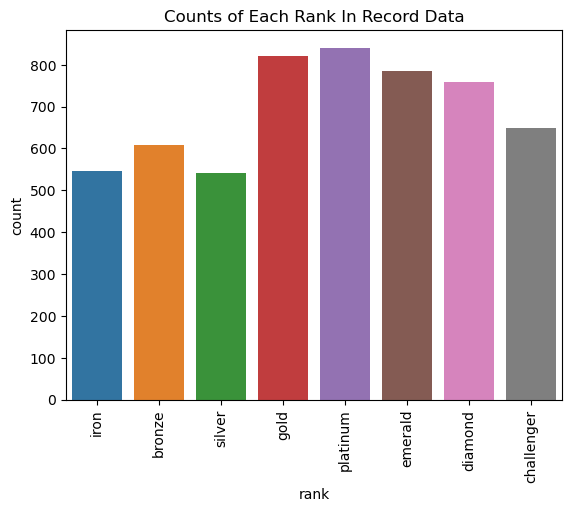

        ranks  counts
0    platinum     841
1        gold     822
2     emerald     786
3     diamond     759
4  challenger     650
5      bronze     609
6        iron     545
7      silver     542


In [3]:
"""
First go through instructions for baseline. 

First step is show and calculate the distribution of class (ranks) labels in record data.
"""

# Simple histogram plot to show the distribution of each rank in the record dataset. 
sns.countplot(x='rank', data = combined_league_ranks)
plt.title('Counts of Each Rank In Record Data')
plt.xticks(rotation = 90)
plt.show()
#the number of samples with given ranks range from ~530 to ~840.


# Now get an actual count of each rank.
rank_dist = combined_league_ranks['rank'].value_counts().reset_index()
rank_dist.columns = ["ranks","counts"]
print(rank_dist)

In [4]:
"""
Now that I have the counts, I figure out the density by dividing by total. 

Then I use the found density distribution of the classes to resample it based on the weights and then figure out predictions with uniform distribution to add randomness.
Then find the accuracy, precision, recall, and f1 scores for the resampled data and the predictions.
"""

#add a column of the probability of the distribution of class labels
rank_dist['prob'] = rank_dist['counts']/sum(rank_dist['counts'])
#add another column to convert the ranks into numbers for the random classifier algorithm
label_encode = LabelEncoder()
rank_dist['ranks_num'] = label_encode.fit_transform(rank_dist['ranks'])

# input the numbered classes and the weights of each class into random.choices() to generate 10,000 sampled dataset
rank_weights = random.choices(list(rank_dist['ranks_num']), weights=list(rank_dist['prob']), k = 10000)


#then input into random classifier code
#Code was provided by DSAN 5100 shared code
ypred=[]
max_label=np.max(rank_weights)
for i in range(0,len(rank_weights)):
    ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

#print accuracy, precision, and recall
print("Random Classifier metric scores:")
print("Accuracy Score:",accuracy_score(rank_weights, ypred))
print("Precision Score:",precision_score(rank_weights, ypred, average='weighted'))
print("Recall Score:",recall_score(rank_weights, ypred, average='weighted'))
print("F1 Score:",f1_score(rank_weights, ypred, average='weighted'))
print("Precision, Recall, and F1 Scores:",precision_recall_fscore_support(rank_weights, ypred))

# As seen in the output accuracy, precision, recall, and F1 scores, it makes sense to see a total accuracy probability of about 0.125 as the distribution of classes for the record data
# is somewhat uniform meaning the total accuracy is about 1/total number of class or 8 which is about 0.125. Next, we can see that total Precision, Recall, and F1-Score sort of follows
# the distribution. This is because the scores are also relatively close to 1.125 again though a little off since the weights are not perfectly uniform. To go into more details on each
# class' precision, recall, and f1 scores the last output shows how each class performed. And we can see that the average precision, recall, and f1 scores are close to the aggregate scores.

Random Classifier metric scores:
Accuracy Score: 0.1206
Precision Score: 0.12346353020210461
Recall Score: 0.1206
F1 Score: 0.12141405817891071
Precision, Recall, and F1 Scores: (array([0.11662727, 0.10995185, 0.1458671 , 0.13333333, 0.1288    ,
       0.0811245 , 0.14705882, 0.10090238]), array([0.13143872, 0.11729452, 0.13081395, 0.11925287, 0.11290323,
       0.1011011 , 0.12475378, 0.12424242]), array([0.12359081, 0.11350456, 0.13793103, 0.12590064, 0.12032885,
       0.09001783, 0.13499112, 0.11136261]), array([1126, 1168, 1376, 1392, 1426,  999, 1523,  990], dtype=int64))


In [8]:
"""
A quick cleaning step to normalize variables with time.
"""

#normalize time-dependent features
#do this for variables: kills, deaths, dmgObj, dmgTurr, vision_score, totalDmg, 
#totalDmgTaken, totalMinions, and gold
combined_league_ranks['kills/min'] = combined_league_ranks['kills']/combined_league_ranks['time']
combined_league_ranks['deaths/min'] = combined_league_ranks['deaths']/combined_league_ranks['time']
combined_league_ranks['dmgObj/min'] = combined_league_ranks['dmgObj']/combined_league_ranks['time']
combined_league_ranks['dmgTurr/min'] = combined_league_ranks['dmgTurr']/combined_league_ranks['time']
combined_league_ranks['vision_score/min'] = combined_league_ranks['vision_score']/combined_league_ranks['time']
combined_league_ranks['dmg/min'] = combined_league_ranks['totalDmg']/combined_league_ranks['time']
combined_league_ranks['dmgTaken/min'] = combined_league_ranks['totalDmgTaken']/combined_league_ranks['time']
combined_league_ranks['minions/min'] = combined_league_ranks['totalMinions']/combined_league_ranks['time']
combined_league_ranks['gold/min'] = combined_league_ranks['gold']/combined_league_ranks['time']


#remove the time-dependent columns
combined_league_ranks = combined_league_ranks.drop('kills', axis=1)
combined_league_ranks = combined_league_ranks.drop('deaths', axis=1)
combined_league_ranks = combined_league_ranks.drop('dmgObj', axis=1)
combined_league_ranks = combined_league_ranks.drop('dmgTurr', axis=1)
combined_league_ranks = combined_league_ranks.drop('vision_score', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalDmg', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalDmgTaken', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalMinions', axis=1)
combined_league_ranks = combined_league_ranks.drop('gold', axis=1)

#remove non-numerical columns and time columns
combined_league_ranks = combined_league_ranks.drop('time', axis=1)
combined_league_ranks = combined_league_ranks.drop('position', axis=1)
combined_league_ranks = combined_league_ranks.drop('win', axis=1)


In [36]:
"""
A very useful module from Sklearn is the GridSearchCV function that searches for the most optimal
hyperparameters for a basic Decision Tree in this part.
"""

# preset some options for hyperparameters then go through the combinations with GridShotCV
param_grid = {'max_depth': [None, 5, 10],'min_samples_split': [2, 5, 10, 20, 40, 80],'min_samples_leaf': [1, 2, 4, 8, 16, 32]}

#split dataset 80/20 = training/testing
x_train, x_test = train_test_split(combined_league_ranks, test_size=0.2, random_state=33)

#pop 'rank' col to make target variables
y_train = x_train.pop("rank")
y_test = x_test.pop("rank")

# now create basic decision tree classifier model
dt_model = DecisionTreeClassifier()

#find best parameters with predefined param_grid
gridsearch = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
gridsearch.fit(x_train, y_train)

#print the best accuracy found and the tuned hyperparameters to use
print("Optimal Hyperparameters:",gridsearch.best_params_)
print("Training accuracy:",gridsearch.best_score_)

#the best accuracy is a little above 20% which is basically what I found in Naive Bayes
#the hyperparam to use: depth = 5, minimum samples for a leaf = 8, minimum samples to make a split = 40

Optimal Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 40}
Training accuracy: 0.20661716271952493


In [34]:
"""
Make basic Decision Tree now with the found optimal hyperparameters.
"""
#redefine the decision tree model
opt_dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=8, min_samples_leaf=40, random_state=33)

#fit it with the training data and targets
opt_dt_model.fit(x_train, y_train)

#get accuracy of the basic decision tree with test data to compare accuracy
opt_dt_accuracy = opt_dt_model.score(x_test, y_test)
print("Test Dataset accuracy:", opt_dt_accuracy)

#it seems the accuracy of testing also outputs a little above 20% accuracy as seen in the training

Test Dataset accuracy: 0.20342034203420342


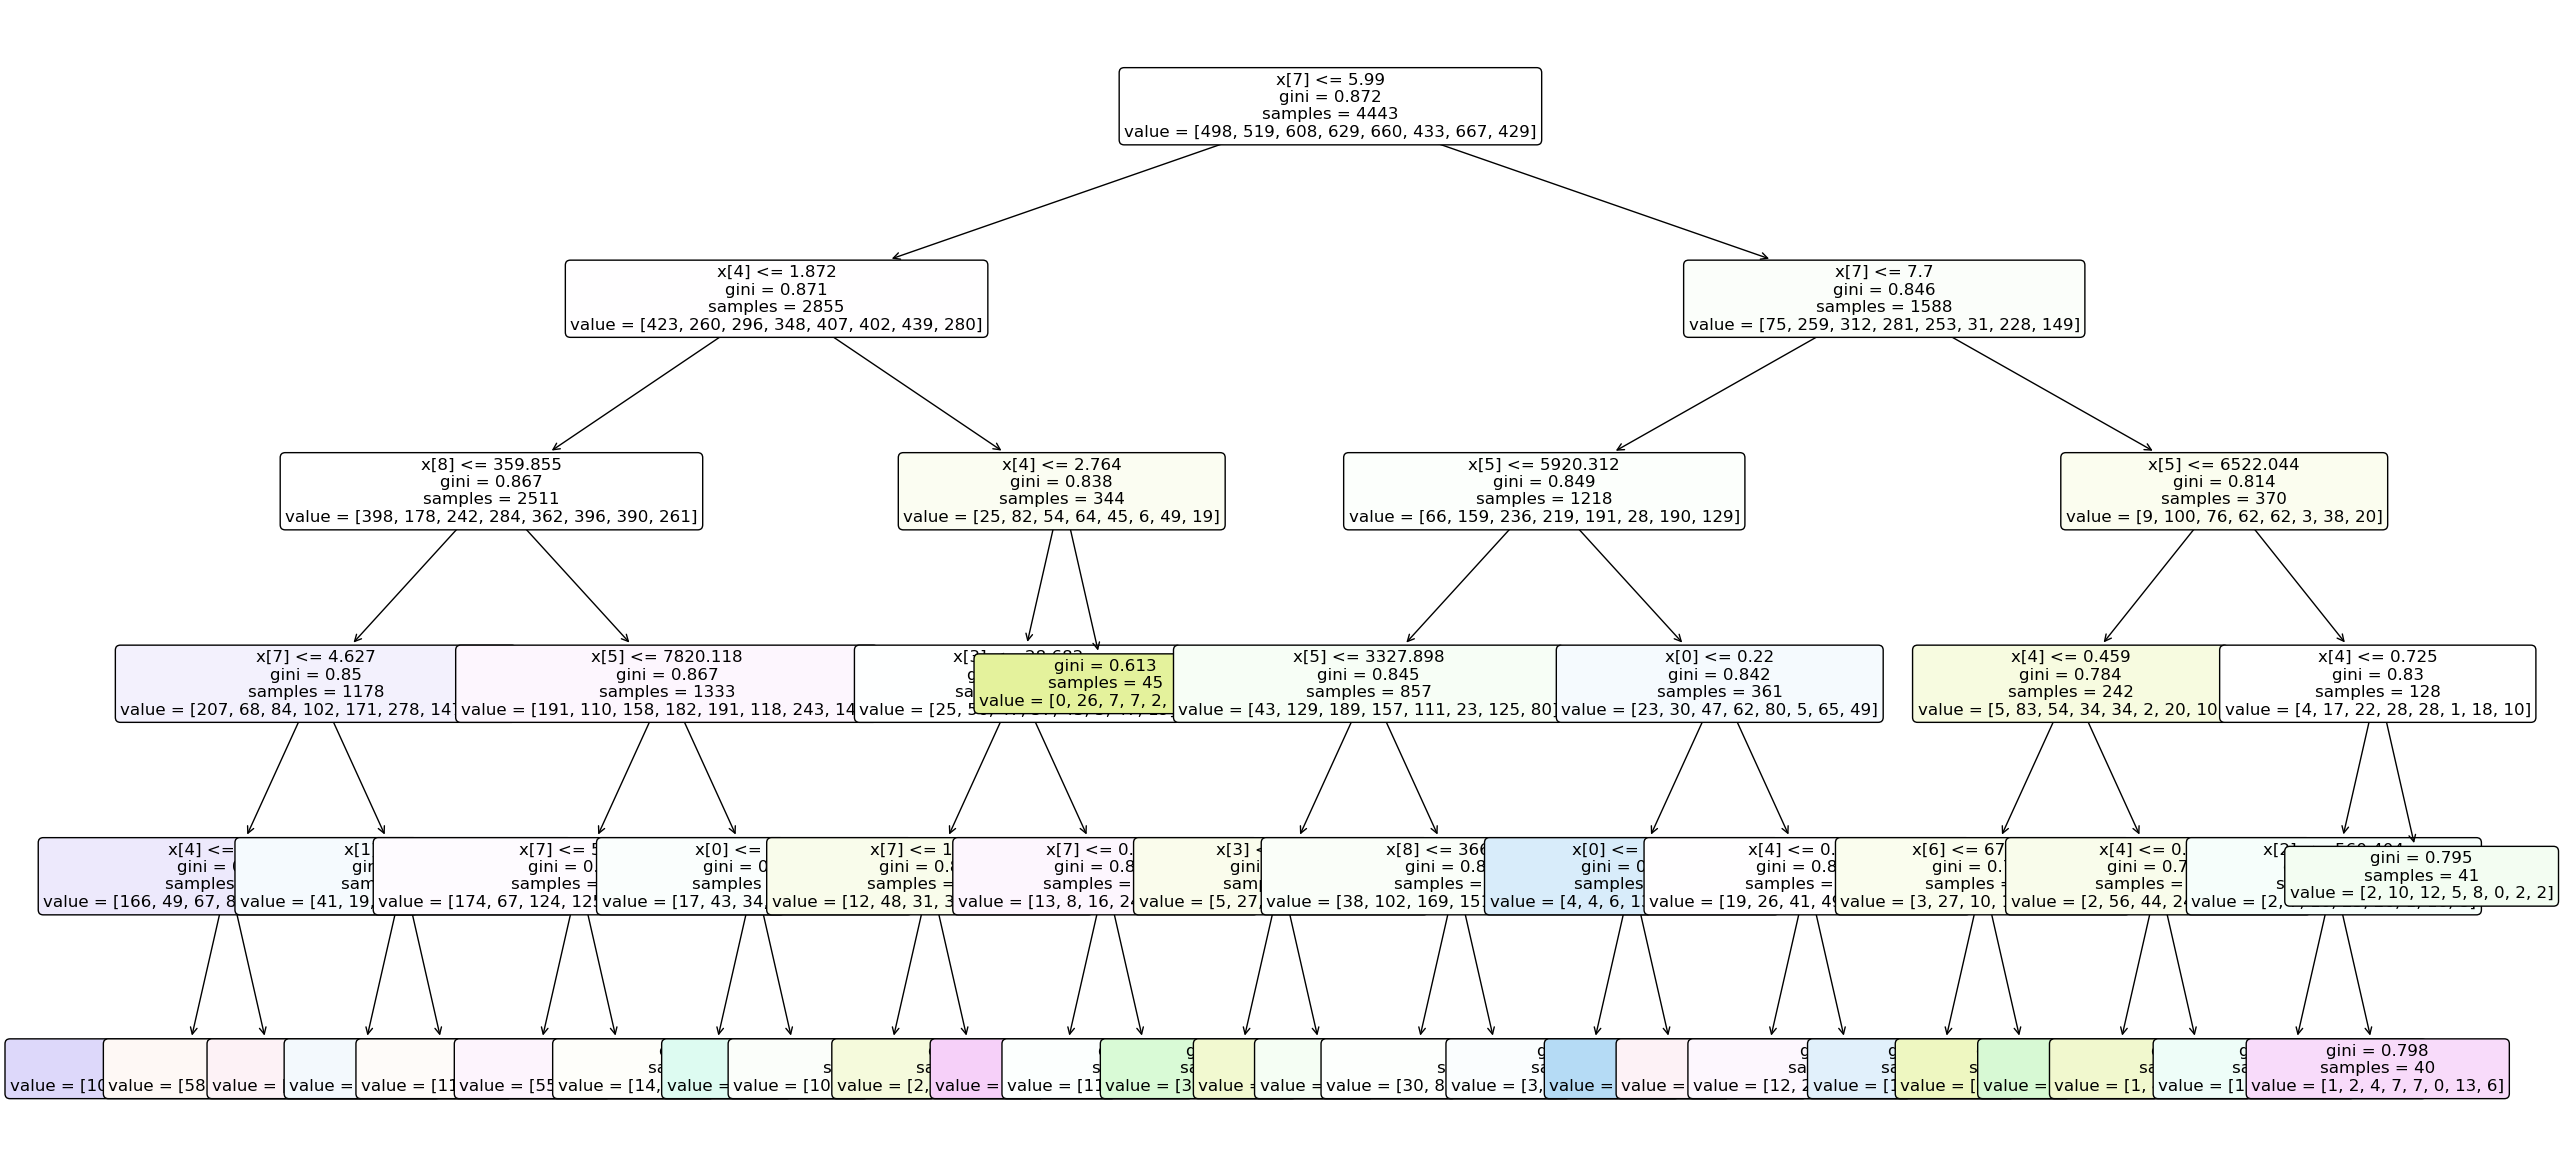

In [37]:
"""
Now visualize the tree and also make a confusion matrix on the predictions from decision tree.
"""
#plot the decision tree itself
plt.figure(figsize=(30,15))
plot_tree(opt_dt_model, filled=True, rounded=True, fontsize=12)
plt.savefig('basic_tree.png', bbox_inches='tight')
plt.show()

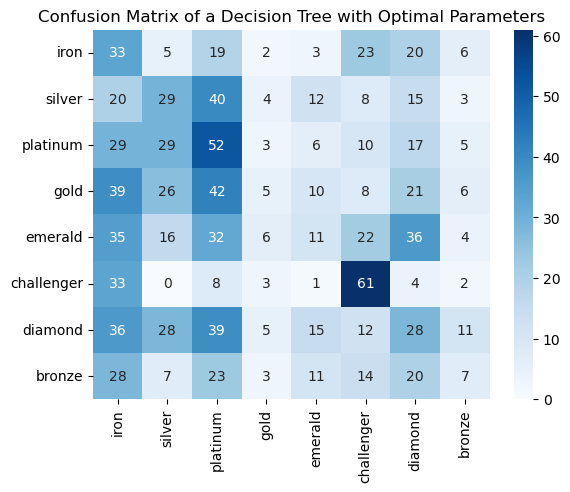

In [48]:
"""
Also visualize the confusion matrix of predictions with the true classes.
"""

#output the predictions of the basic decision tree classifier
test_preds = opt_dt_model.predict(x_test)
conf = confusion_matrix(y_test, test_preds)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels= y_train.unique(), yticklabels=y_train.unique())
plt.savefig('basic_tree_conf.png', bbox_inches='tight')
plt.title('Confusion Matrix of a Decision Tree with Optimal Parameters')
plt.show()

# From the confusion matrix here, it seemed that platinum and iron were predicted the most.
# Additionally, platinum and challenger had the highest predicted correctly. That means
# the data might be too complicated for a basic decision tree.

In [45]:
"""
Now do the same process with finding the optimal hyperparameters but with Random Forest.
"""
#predefine parameter options
param_grid_rf = {'n_estimators': [50, 100, 150],'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

#RF model
rf_model = RandomForestClassifier(random_state=33)

#now do gridsearch again on the RF model with diff combos of predefined parameter options
gridsearch_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
#also fit with train data and targets
gridsearch_rf.fit(x_train, y_train)

print("Optimal hyperparameters:", gridsearch_rf.best_params_)
print("Optimal Model Accuracy: ", gridsearch_rf.best_score_)

#from this very long process (9.5 min) I found that the optimal hyperparameters to use for RF
#is 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150
#which actually increased the model accuracy to about 23% which is actually an increase from 
#the 20% I found earlier.

Optimal hyperparameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Optimal Model Accuracy:  0.23340427041214445


Test Dataset accuracy: 0.23852385238523852


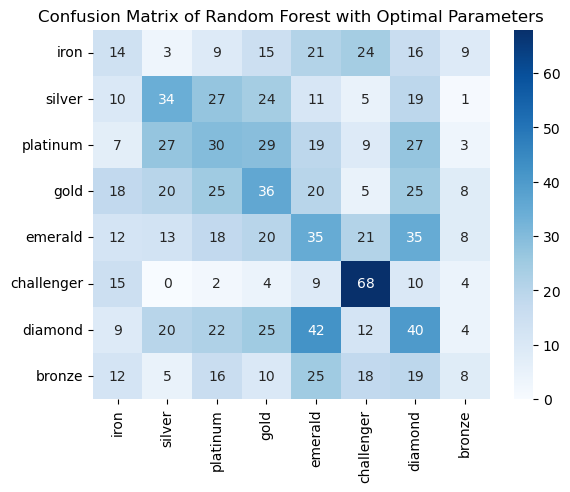

In [49]:
"""
Now do the RF with those parameters and a Confusion Matrix.

Since making the entire forest is impossible to show in a plot, I will skip that step for this.
"""

#optimal RF
opt_rf = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_split=10, min_samples_leaf=2, random_state=33)

#train RF with the train dataset
opt_rf.fit(x_train, y_train)

#accuracy of testing dataset
print("Test Dataset accuracy:", opt_rf.score(x_test, y_test))

#again the test dataset has a similar accuracy but is actually slightly more accurate as
#the accuracy is close to 30% now.


#Plot confusion matrix of the new predictions with RF
test_preds_rf = opt_rf.predict(x_test)
conf = confusion_matrix(y_test, test_preds_rf)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels= y_train.unique(), yticklabels=y_train.unique())
plt.savefig('rf_conf.png', bbox_inches='tight')
plt.title('Confusion Matrix of Random Forest with Optimal Parameters')
plt.show()

#this confusion matrix looks a bit more spread out instead of focusing on specific ranks. What is
#consistent is that Challenger is still being correctly predicted massively compared to other ranks.
#Though the diagonal of predictions of the ranks is a lot more apparent now. This definitely shows
#why the accuracy higher from Random Forest.